# Vision transformer


## Import libraries

In [276]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt


In [277]:
import sys
CURR_DIR = "/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/hw05"

sys.path.append(CURR_DIR)

# from attention_mnist_utils import *

from attention_mnist_utils import (
    # get_attention_map,
    image_to_patches,
    train,
    MLP,
    evaluate_classification,
)
from IPython.display import clear_output

## Setting some parameters

In [278]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


## Downloading MNIST from torchvision

In [279]:
# set the preprocess operations to be performed on train/val/test samples
preprocessing_transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(
    root="./data/torchvision/MNIST/training",
    train=True,
    download=True,
    transform=preprocessing_transformation,
)
train_set, test_set = torch.utils.data.random_split(train_dataset, [1000, 59000])

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=32, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=True)

Let's check that we have the correct number of samples in our dataloader

In [280]:
len(train_loader.dataset), len(test_loader.dataset)

(1000, 59000)

Let's see how many batches we have in the dataloader

In [281]:
len(train_loader), len(test_loader)

(32, 1844)

Let's pick four example images

In [282]:
n_images = 4
examples_imgs = torch.stack([test_set[idx][0] for idx in range(n_images)], dim=0)

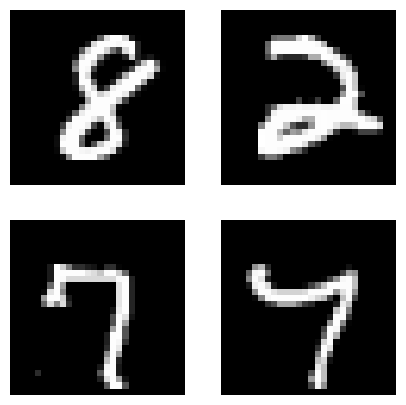

In [283]:
plt.figure(figsize=(5, 5))
for i in range(n_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(examples_imgs[i, 0], cmap="gray")
    plt.axis("off")
plt.show()

## Visualizing `image_to_patches` function

We first transform the four examples images to patches.

In [284]:
# image size in one dimension (whole image is of shape (image_size , image_size)
image_size = 28

# patch size in one dimension (whole patch is of shape (patch_size , patch_size)
patch_size = 4

# total number of patches
num_patches = int((image_size / patch_size) ** 2)

In [285]:
img_patches = image_to_patches(examples_imgs, patch_size=patch_size)
img_patches.shape

torch.Size([4, 49, 16])

This shape corresponds to 4 images with 49 (7x7) patches, each consisting of 16 pixels (4x4). For the model, this shape is fine, but for visualizing the patched image we need to reshape it.

In [286]:
num_patch_per_dim = int(np.sqrt(num_patches))

In [287]:
image = img_patches[1].reshape(7, 7, 4, 4)

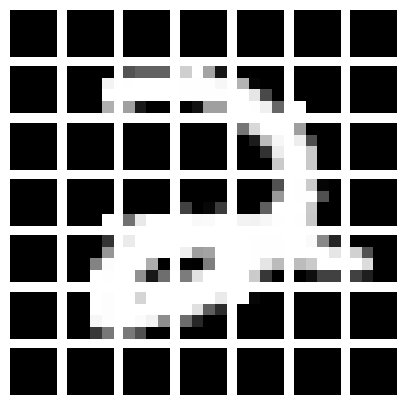

In [288]:
plt.figure(figsize=(5, 5))
k = 0
for i in range(num_patch_per_dim):
    for j in range(num_patch_per_dim):
        k += 1

        plt.subplot(num_patch_per_dim, num_patch_per_dim, k)
        plt.imshow(image[i, j], cmap="gray")
        plt.axis("off")

## VisionTransformer class

In [289]:
import torch
import torch.nn.functional as F


class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.scale = 1.0 / (d_model**0.5)

        # Define linear layers for queries, keys, and values
        self.query_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)
        self.key_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)
        self.value_linear = torch.nn.Linear(out_features=d_model, in_features=d_model)

    def forward(self, keys, queries, values):
        """
        Args:
            keys: tensor of shape (batch_size, d_seq, d_model)
            queries: tensor of shape (batch_size, d_seq, d_model)
            values: tensor of shape (batch_size, d_seq, d_model)

        Returns:
            context: tensor of shape (batch_size, d_seq, d_model)
        """
        # Project x to query, key, and value
        query = self.query_linear(queries)  # shape: (batch_size, d_seq, d_model)
        key =  self.key_linear(keys)   # shape: (batch_size, d_seq, d_model)
        value = self.value_linear(values)   # shape: (batch_size, d_seq, d_model)

        # Compute scaled dot product
        attn_scores = torch.matmul(query, key.transpose(-2, -1))
        scaled_attn_scores = attn_scores * self.scale 

        # Compute attention weights
        attn_weights = F.softmax(scaled_attn_scores, dim=-1)
        attention = torch.matmul(attn_weights, value)  # shape: (batch_size, d_seq, d_model)

        return attention
  

In [290]:
# TESTING ONLY!!!
batch_size = 32
d_seq = 27
d_model = 10
keys = torch.rand(batch_size, d_seq, d_model)
queries = torch.rand(batch_size, d_seq, d_model)
values = torch.rand(batch_size, d_seq, d_model)

attention = ScaledDotProductAttention(d_model)
attention.forward(keys, queries, values)

tensor([[[-0.0292, -0.5270, -0.3946,  ..., -0.4480,  0.0900, -0.5239],
         [-0.0290, -0.5276, -0.3949,  ..., -0.4464,  0.0884, -0.5219],
         [-0.0294, -0.5290, -0.3947,  ..., -0.4464,  0.0882, -0.5218],
         ...,
         [-0.0282, -0.5264, -0.3952,  ..., -0.4470,  0.0897, -0.5218],
         [-0.0289, -0.5264, -0.3952,  ..., -0.4475,  0.0904, -0.5235],
         [-0.0287, -0.5273, -0.3959,  ..., -0.4467,  0.0893, -0.5210]],

        [[-0.0819, -0.5547, -0.3491,  ..., -0.4251,  0.0074, -0.5484],
         [-0.0817, -0.5543, -0.3494,  ..., -0.4252,  0.0066, -0.5489],
         [-0.0821, -0.5556, -0.3503,  ..., -0.4257,  0.0067, -0.5481],
         ...,
         [-0.0818, -0.5545, -0.3490,  ..., -0.4248,  0.0075, -0.5489],
         [-0.0815, -0.5540, -0.3492,  ..., -0.4250,  0.0066, -0.5489],
         [-0.0819, -0.5547, -0.3492,  ..., -0.4252,  0.0072, -0.5480]],

        [[-0.0446, -0.4910, -0.3209,  ..., -0.4257,  0.0603, -0.5195],
         [-0.0452, -0.4905, -0.3216,  ..., -0

In [291]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model):
        """
        Inputs:
            d_model - Feature dimension
        """
        super().__init__()

        self.self_attention =  ScaledDotProductAttention(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )

    def forward(self, x):

        attention = self.self_attention(x, x, x)

        # Residual attention update
        x = x + attention

        # Residual MLP update
        x = x + self.mlp(x)
        return x

In [292]:
batch_size = 2
d_seq = 4
d_model = 8

x = torch.rand(batch_size, d_seq, d_model)

self_attention_block = SelfAttentionBlock(d_model=d_model)
output = self_attention_block(x)

print(output.shape)  # Expected: (batch_size, d_seq, d_model)


torch.Size([2, 4, 8])


In [293]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        d_model,
        num_layers,
        num_classes,
        patch_size,
    ):
        """
        Inputs:
            d_model - Dimensionality of the input feature vectors to the Transformer
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension

        """
        super().__init__()

        self.patch_size = patch_size

        self.linear_in = nn.Linear(patch_size * patch_size, d_model)

        self.transformer = nn.Sequential(
            *(SelfAttentionBlock(d_model) for _ in range(num_layers))
        )
        self.linear_out = nn.Linear(d_model, num_classes)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))

    def forward(self, x):

        # Image to patches
        x = image_to_patches(x, self.patch_size)

        # Embed patches
        x = self.linear_in(x)  # x.shape ---> n_samples, n_patches, d_model

        n_samples, _, _ = x.shape

        # Concatenate the class token with the patch features
        cls_token = self.class_token.repeat(n_samples, 1, 1)
        x = torch.cat(
            [cls_token, x], dim=1
        )  # x.shape ---> (n_samples,n_patches+1, d_model)

        # Transformer update
        x = self.transformer(x)

        # Perform classification prediction
        class_features = x[:, 0, :]

        class_prediction = self.linear_out(class_features) 
        return class_prediction

## Initializing the model

We use the following hyperparameters for our model.

In [294]:
d_model = 64
num_layers = 6

num_classes = 10

In [295]:
model = VisionTransformer(
    d_model=d_model,
    num_layers=num_layers,
    patch_size=patch_size,
    num_classes=num_classes,
).to(device)

In [296]:
def count_parameters(self):
    """
    Counts the number of trainable parameters.

    """
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [297]:
count_parameters(model)

126602

## Training

In [298]:
NUM_EPOCHS = 1000

In [299]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [300]:
losses = []
accuracies = []

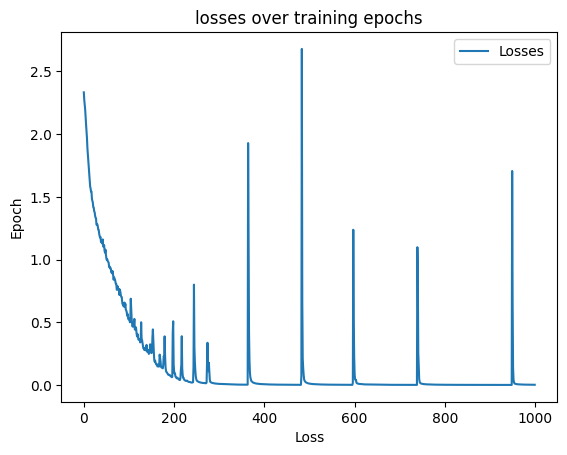

In [301]:
log_interval = 1
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(model, train_loader, optimizer, loss_fn, device)
    losses.append(loss)
    # if epoch % 10 == 0:
    #    accuracies.append(float(evaluate_classification(model, loss_fn, test_loader, device)[1]))
    # elif (len(accuracies) == 0):
    #     accuracies.append(0)
    # else:
    #     accuracies.append(accuracies[-1])  
    # print(accuracies)

    # if epoch % log_interval == 0:
    #     print(f"Train Epoch: {epoch} Loss: {loss:.6f}")

    clear_output(wait=True)
    #     fig, axes = plt.subplots(1, 2, figsize=(12, 5))


    #     axes[0].plot(losses, label="losses")
    #     axes[0].set_title("Linear Scale Loss")
    #     axes[0].set_xlabel("Epoch")
    #     axes[0].set_ylabel("Loss")
    #     # axes[0].legend()

    #     ax2_0 = axes[0].twinx()
    #     ax2_0.plot(accuracies, label="Accuracy", color='green')
    #     ax2_0.set_ylabel("Accuracy (%)", color='green')
    #     ax2_0.tick_params(axis='y', labelcolor='green')
    #     ax2_0.legend(loc="upper right")

    #     axes[1].plot(losses, label="dist")
    #     axes[1].set_yscale('log')
    #     axes[1].set_title("Log Scale Loss")
    #     axes[1].set_xlabel("Epoch")
    #     axes[1].set_ylabel("Loss")
    #     axes[1].set_yscale('log') 
    #     # axes[1].legend()


    #     ax2_1 = axes[1].twinx()
    #     ax2_1.plot(accuracies, label="Accuracy", color='green')
    #     ax2_1.set_ylabel("Accuracy (%)", color='green')
    #     ax2_1.tick_params(axis='y', labelcolor='green')
    #     ax2_1.legend(loc="upper right")
        

    #     plt.tight_layout()
    #     plt.show()


    plt.plot(losses, label="Losses")
    # plt.yscale('log')
    plt.title("losses over training epochs")
    plt.xlabel("Loss")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()
    # # validate(model, lossv, testloader, criterion, accv)

In [302]:
for loss in losses:
  accuracies.append(float(evaluate_classification(model, loss_fn, test_loader, device)[1]))
accuracies

KeyboardInterrupt: 

In [303]:
float(evaluate_classification(model, loss_fn, test_loader, device)[1])

49.4559326171875

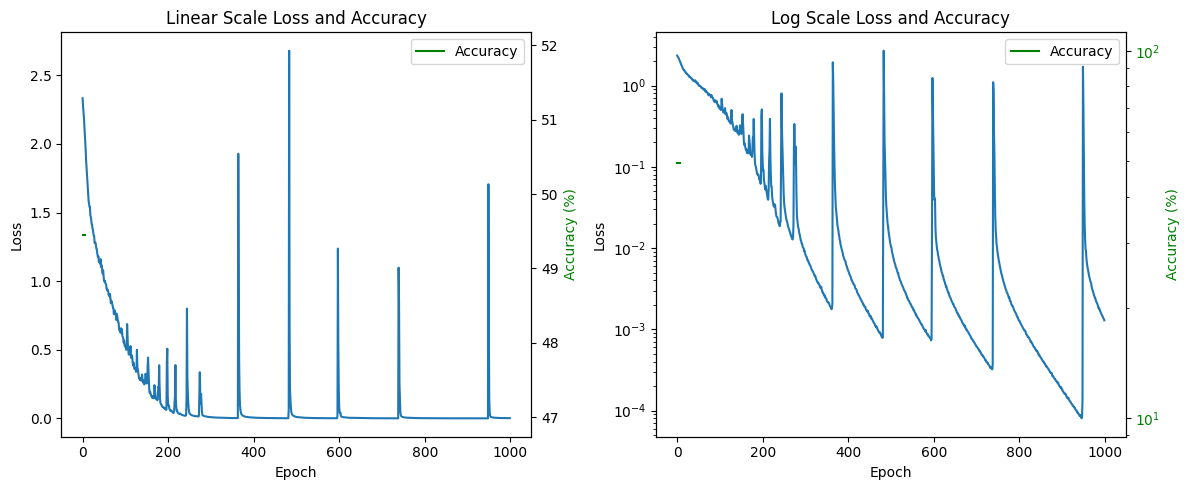

In [304]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# accuracies = range(10)
# losses = range(10)[::-1]

axes[0].plot(losses, label="losses")
axes[0].set_title("Linear Scale Loss and Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
# axes[0].legend()

ax2_0 = axes[0].twinx()
ax2_0.plot(accuracies, label="Accuracy", color='green')
ax2_0.set_ylabel("Accuracy (%)", color='green')
# ax2_0.tick_params(axis='y', labelcolor='green')
ax2_0.legend(loc="upper right")

axes[1].plot(losses, label="dist")
# axes[1].set_yscale('log')
axes[1].set_title("Log Scale Loss and Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
# axes[1].set_yscale('log') 
# axes[1].legend()
# axes[1].set_yscale('log')


ax2_1 = axes[1].twinx()
ax2_1.plot(accuracies, label="Accuracy", color='green')
ax2_1.set_ylabel("Accuracy (%)", color='green')
ax2_1.tick_params(axis='y', labelcolor='green')
ax2_1.legend(loc="upper right")
ax2_1.set_yscale('log') 
axes[1].set_yscale('log')


plt.tight_layout()
plt.show()

In [ ]:
accuracies


[50.88135528564453]

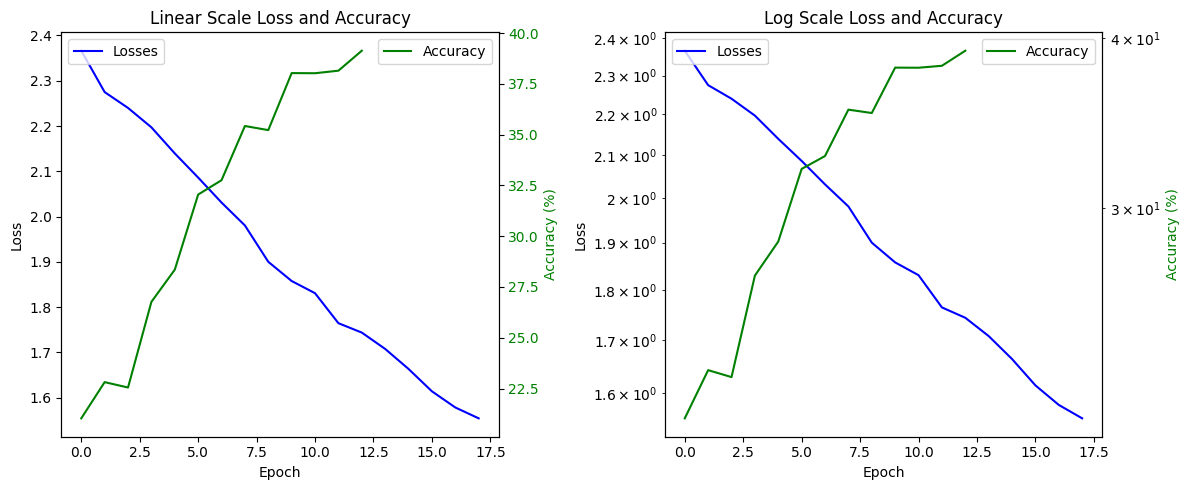

In [ ]:
import matplotlib.pyplot as plt

# Sample data
losses = [
    2.3663787618279457, 2.2749839797616005, 2.2399455681443214,
    2.1970881819725037, 2.1394833363592625, 2.08613645657897,
    2.0309177935123444, 1.980289876461029, 1.9000071585178375,
    1.857557613402605, 1.830612551420927, 1.764369834214449,
    1.7436160780489445, 1.7074979282915592, 1.6632465906441212,
    1.6138472706079483, 1.5781766027212143, 1.554148379713297
]
accuracies = [
    21.033897399902344, 22.81694984436035, 22.55084800720215,
    26.767797470092773, 28.352542877197266, 32.050846099853516,
    32.757625579833984, 35.42542266845703, 35.22372817993164,
    38.03050994873047, 38.02372741699219, 38.14915084838867,
    39.1322021484375
]

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First plot (Linear scale for losses)
axes[0].plot(losses, label="Losses", color='blue')
axes[0].set_title("Linear Scale Loss and Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Create a secondary y-axis for accuracies in the first plot
ax2_0 = axes[0].twinx()
ax2_0.plot(accuracies, label="Accuracy", color='green')
ax2_0.set_ylabel("Accuracy (%)", color='green')
ax2_0.tick_params(axis='y', labelcolor='green')
ax2_0.legend(loc="upper right")  # Accuracy legend

# Manually add legend for the main axis
axes[0].legend(loc="upper left")  # Losses legend

# Second plot (Log scale for both losses and accuracies)
axes[1].plot(losses, label="Losses", color='blue')
axes[1].set_title("Log Scale Loss and Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

# Set log scale for the primary y-axis of the second plot
axes[1].set_yscale('log')  # Apply log scale to primary y-axis

# Create a secondary y-axis for accuracies in the second plot
ax2_1 = axes[1].twinx()
ax2_1.plot(accuracies, label="Accuracy", color='green')
ax2_1.set_ylabel("Accuracy (%)", color='green')
ax2_1.tick_params(axis='y', labelcolor='green')
ax2_1.legend(loc="upper right")  # Accuracy legend

# Set log scale for the secondary y-axis of the second plot as well
ax2_1.set_yscale('log')  # Apply log scale to the secondary y-axis as well

# Manually add legend for the main axis in the second plot
axes[1].legend(loc="upper left")  # Losses legend for the main axis

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
evaluate_classification(model, loss_fn, test_loader, device)


(6.858793378393458, tensor(50.1220))

## Picking one test sample and running it through the first attention block

In [ ]:
test_sample_index = (test_set.dataset.targets == 7).nonzero(as_tuple=True)[0][10].item()
test_sample_index

101

In [ ]:
# pull out one test sample
image = test_set.dataset[test_sample_index][0][0].to(device)

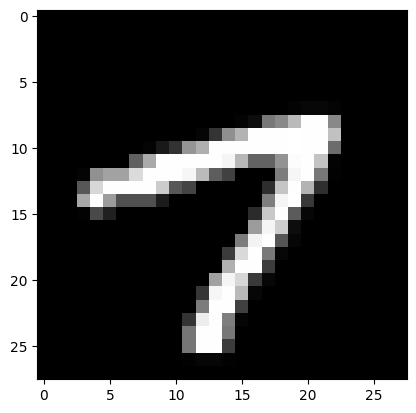

In [ ]:
plt.imshow(image.cpu(), cmap="gray")

We can compute the attention by embedding the data and the manually computing the map.

In [ ]:
image.shape

torch.Size([28, 28])

In [ ]:
x = image_to_patches(image.reshape(1, 1, 28, 28), model.patch_size)

x_embedded = model.linear_in(x)

class_token = model.class_token.repeat(1, 1, 1)

x_cat = torch.cat(
    [class_token, x_embedded], dim=1
)  # shape should be (num_patches+1, n_samples, embed_dim)

queries = model.transformer[0].self_attention.query_linear.weight
keys = model.transformer[0].self_attention.key_linear.weight
weights = model.transformer[0].self_attention.value_linear.weight  # shape: (batch_size, d_seq, d_seq)

print(queries, keys, weights)
print(weights.shape)

Parameter containing:
tensor([[-0.0295, -0.1002,  0.0013,  ...,  0.0869,  0.0279,  0.0740],
        [ 0.1243,  0.0703,  0.0303,  ...,  0.0151,  0.0422, -0.0740],
        [ 0.0668, -0.0477, -0.1213,  ...,  0.1114, -0.0136, -0.1285],
        ...,
        [ 0.0268,  0.0504,  0.0727,  ..., -0.0141,  0.0075, -0.0354],
        [ 0.1429,  0.0410, -0.0021,  ..., -0.1269,  0.0107,  0.0020],
        [-0.0439,  0.1224,  0.0536,  ..., -0.1271,  0.1425, -0.0310]],
       requires_grad=True) Parameter containing:
tensor([[ 0.0901, -0.1361,  0.1058,  ...,  0.0387, -0.1039, -0.0252],
        [-0.0088, -0.0456, -0.0978,  ..., -0.0671, -0.0102,  0.0152],
        [ 0.0184,  0.0178,  0.0257,  ...,  0.0195, -0.1577,  0.0773],
        ...,
        [-0.0832, -0.0534,  0.0916,  ..., -0.0821,  0.0955,  0.0036],
        [ 0.0283,  0.0573,  0.0538,  ..., -0.1307, -0.0063,  0.0918],
        [ 0.0288,  0.0922,  0.0571,  ...,  0.0254,  0.1404, -0.0745]],
       requires_grad=True) Parameter containing:
tensor([[ 0.

We can interpolate the map back to 28x28 pixels.

torch.Size([28, 28])


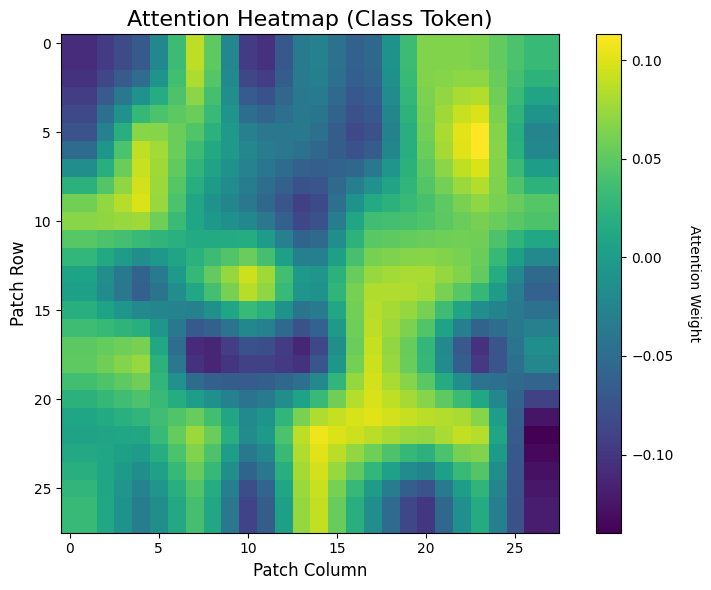

In [305]:
attn_weights_class_token = weights[0, 1:]  # Shape: (63,)

# Reshape into a square grid (e.g., 7x9 for num_patches=63)
num_patches = int(attn_weights_class_token.shape[0] ** 0.5)  # 63 -> 7x9 grid
attn_heatmap = attn_weights_class_token.reshape(1, 1, 7, 9)

# Resize to the desired image size (28x28)
image_size = 28
attn_heatmap_resized = F.interpolate(
    attn_heatmap,
    [image_size, image_size],  # Target size (28, 28)
    mode="bilinear",  # Use bilinear interpolation
    align_corners=False
).view(image_size, image_size)  # Flatten to 2D (28, 28)

# Now attn_heatmap_resized is the resized attention heatmap of shape (28, 28)
print(attn_heatmap_resized.shape)  # Should print: torch.Size([28, 28])

plt.figure(figsize=(8, 6))

# Visualize the attention heatmap using matplotlib
plt.imshow(attn_heatmap_resized.cpu().detach().numpy(), cmap='viridis')
# plt.colorbar()
cbar = plt.colorbar()
cbar.set_label('Attention Weight', rotation=270, labelpad=20)

plt.title("Attention Heatmap (Class Token)", fontsize=16)
plt.xlabel("Patch Column", fontsize=12)
plt.ylabel("Patch Row", fontsize=12) 
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()



In [ ]:
# print(weights[0,0,1:].shape)
print(weights.shape)


torch.Size([64, 64])


In [ ]:
attn_heatmap_resized = F.interpolate(
    weights[0, 0, 1:].reshape(1, 1, 8, 8),
    [image_size, image_size],
    mode="bilinear",
).view(28, 28)

IndexError: too many indices for tensor of dimension 2

In [ ]:
attn_heatmap_resized.shape

In [ ]:
plt.imshow(attn_heatmap_resized.cpu().detach().numpy())

In [ ]:
plt.imshow(weights[0, 0, 1:].detach().numpy().reshape(7, 7))